In [2]:
import sys
import yaml
import phate
import torch
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import scipy
import numpy as np
from math import pi
import matplotlib.pyplot as plt
from typing import Optional, List
from torchdyn.core import NeuralODE


In [87]:
def sphere_metric(x):
    n = x.shape[0]
    theta, phi = x[:, 0], x[:, 1]

    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1
    metric[:, 1, 1] = torch.sin(theta) ** 2
    return metric

def euc_metric(x):
    n = x.shape[0]
    metric = torch.zeros(n, 2, 2)
    metric[:, 0, 0] = 1.0
    metric[:, 1, 1] = 1.0
    return metric

def hyperb_metric(x):
    n = x.shape[0]
    mu, sigma2 = x[:,0], x[:,1]
    metric = torch.zeros(n, 2, 2)
    metric[:,0,0] = 1/sigma2
    metric[:,1,1] = 2/sigma2
    return metric


def polar_to_euc(mat):
    """mat (np.array): N X D
    N: number of observation in the path
    D: dimension (theta,psi)"""
    N, D = mat.shape
    coor = np.empty((N, 3))
    for i in range(N):
        theta, psi = mat[i, :]
        coor[i, :] = (
            np.sin(theta) * np.cos(psi),
            np.sin(theta) * np.sin(psi),
            np.cos(theta),
        )

    return coor


def euc_to_polar(mat):
    """mat (np.array) N X 3 return the corresponding polar coordinates."""
    N, _ = mat.shape
    coor = np.empty((N, 2))
    for i in range(N):
        x, y, z = mat[i, :]
        coor[i, :] = (np.arctan((np.sqrt(x**2 + y**2) / z)), np.arctan(y / x))
    return coor


def great_circle(x0, x1, omega):
    """Great circle passing by `x0` and `x1`."""
    u = x0
    w = np.cross(x0, x1)
    w = w / np.linalg.norm(w)
    v = np.cross(u, w)

    return u * np.cos(omega) + v * np.sin(omega)


def path_interval(path):
    theta_min = 0 <= path[:, 0].min()
    theta_max = path[:, 0].max() <= pi
    theta = theta_min and theta_max
    psi_min = 0 <= path[:, 1].min()
    psi_max = path[:, 1].max() <= 2 * pi
    psi = psi_min and psi_max

    return theta, psi


from torch import nn

ACTIVATION_MAP = {
    "relu": nn.ReLU,
    "sigmoid": nn.Sigmoid,
    "tanh": nn.Tanh,
    "selu": nn.SELU,
    "elu": nn.ELU,
    "lrelu": nn.LeakyReLU,
    "softplus": nn.Softplus,
}


class SimpleDenseNet(nn.Module):
    def __init__(
        self,
        input_size: int,
        target_size: int,
        activation: str,
        batch_norm: bool = True,
        hidden_dims: Optional[List[int]] = None,
    ):
        super().__init__()
        if hidden_dims is None:
            hidden_dims = [256, 256, 256]
        dims = [input_size, *hidden_dims, target_size]
        layers = []
        for i in range(len(dims) - 2):
            layers.append(nn.Linear(dims[i], dims[i + 1]))
            if batch_norm:
                layers.append(nn.BatchNorm1d(dims[i + 1]))
            layers.append(ACTIVATION_MAP[activation]())
        layers.append(nn.Linear(dims[-2], dims[-1]))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class TimeInvariantVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        del t
        return self.model(x)


class VelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        """ignore t run model."""
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        return self.model(x)


class Regularizer(nn.Module):
    def __init__(self):
        pass


def _batch_root_mean_squared(tensor):
    tensor = tensor.view(tensor.shape[0], -1)
    return torch.norm(tensor, p=2, dim=1) / tensor.shape[1] ** 0.5


class RegularizationFunc(nn.Module):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        """Outputs a batch of scaler regularizations."""
        raise NotImplementedError


class L1Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.mean(torch.abs(dx), dim=1)


class L2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return _batch_root_mean_squared(dx)


class SphereReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, sphere_metric(x), dx)
    
class HyperReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, hyperb_metric(x), dx)

class EucReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        return torch.einsum("bi,bij,bj->b", dx, euc_metric(x), dx)


class SquaredL2Reg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        to_return = dx.view(dx.shape[0], -1)
        return torch.pow(torch.norm(to_return, p=2, dim=1), 2)


def _get_minibatch_jacobian(y, x, create_graph=True):
    """Computes the Jacobian of y wrt x assuming minibatch-mode.
    Args:
      y: (N, ...) with a total of D_y elements in ...
      x: (N, ...) with a total of D_x elements in ...
    Returns:
      The minibatch Jacobian matrix of shape (N, D_y, D_x)
    """
    # assert y.shape[0] == x.shape[0]
    y = y.view(y.shape[0], -1)

    # Compute Jacobian row by row.
    jac = []
    for j in range(y.shape[1]):
        dy_j_dx = torch.autograd.grad(
            y[:, j],
            x,
            torch.ones_like(y[:, j]),
            retain_graph=True,
            create_graph=create_graph,
        )[0]
        jac.append(torch.unsqueeze(dy_j_dx, -1))
    jac = torch.cat(jac, -1)
    return jac


class JacobianFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        jac = _get_minibatch_jacobian(dx, x)
        context.jac = jac
        return _batch_root_mean_squared(jac)


class JacobianDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        return _batch_root_mean_squared(diagonal)


class JacobianOffDiagFrobeniusReg(RegularizationFunc):
    def forward(self, t, x, dx, context) -> torch.Tensor:
        if hasattr(context, "jac"):
            jac = context.jac
        else:
            jac = _get_minibatch_jacobian(dx, x)
            context.jac = jac
        diagonal = jac.view(jac.shape[0], -1)[
            :, :: jac.shape[1]
        ]  # assumes jac is minibatch square, ie. (N, M, M).
        ss_offdiag = torch.sum(jac.view(jac.shape[0], -1) ** 2, dim=1) - torch.sum(
            diagonal**2, dim=1
        )
        ms_offdiag = ss_offdiag / (diagonal.shape[1] * (diagonal.shape[1] - 1))
        return ms_offdiag


def autograd_trace(x_out, x_in, **kwargs):
    """Standard brute-force means of obtaining trace of the Jacobian, O(d) calls to autograd."""
    trJ = 0.0
    for i in range(x_in.shape[1]):
        trJ += torch.autograd.grad(
            x_out[:, i].sum(), x_in, allow_unused=False, create_graph=True
        )[0][:, i]
    return trJ


class CNFReg(RegularizationFunc):
    def __init__(self, trace_estimator=None, noise_dist=None):
        super().__init__()
        self.trace_estimator = (
            trace_estimator if trace_estimator is not None else autograd_trace
        )
        self.noise_dist, self.noise = noise_dist, None

    def forward(self, t, x, dx, context):
        # TODO we could check if jac is in the context to speed up
        return -self.trace_estimator(dx, x, noise=self.noise)


class AugmentationModule(nn.Module):
    """Class orchestrating augmentations.
    Also establishes order.
    """

    def __init__(
        self,
        cnf_estimator: str = None,
        l1_reg: float = 0.0,
        l2_reg: float = 0.0,
        sphere_reg: float = 0.0,
        euc_reg: float = 0.0,
        hyper_reg:float = 0.0,
        squared_l2_reg: float = 0.0,
        jacobian_frobenius_reg: float = 0.0,
        jacobian_diag_frobenius_reg: float = 0.0,
        jacobian_off_diag_frobenius_reg: float = 0.0,
    ) -> None:
        super().__init__()
        self.cnf_estimator = cnf_estimator
        names = []
        coeffs = []
        regs = []
        if cnf_estimator == "exact":
            names.append("log_prob")
            coeffs.append(1)
            regs.append(CNFReg(None, noise_dist=None))
        if l1_reg > 0.0:
            names.append("L1")
            coeffs.append(l1_reg)
            regs.append(L1Reg())
        if l2_reg > 0.0:
            names.append("L2")
            coeffs.append(l2_reg)
            regs.append(L2Reg())
        if sphere_reg > 0.0:
            names.append("Sphere metric")
            coeffs.append(sphere_reg)
            regs.append(SphereReg())
        if euc_reg > 0.0:
            names.append("Euclidean metric")
            coeffs.append(euc_reg)
            regs.append(EucReg())
        if hyper_reg > 0.0:
            names.append("Hyperbolic metric")
            coeffs.append(hyper_reg)
            regs.append(HyperReg())
        if squared_l2_reg > 0.0:
            names.append("squared_L2")
            coeffs.append(squared_l2_reg)
            regs.append(SquaredL2Reg())
        if jacobian_frobenius_reg > 0.0:
            names.append("jacobian_frobenius")
            coeffs.append(jacobian_frobenius_reg)
            regs.append(JacobianFrobeniusReg())
        if jacobian_diag_frobenius_reg > 0.0:
            names.append("jacobian_diag_frobenius")
            coeffs.append(jacobian_diag_frobenius_reg)
            regs.append(JacobianDiagFrobeniusReg())
        if jacobian_off_diag_frobenius_reg > 0.0:
            names.append("jacobian_off_diag_frobenius")
            coeffs.append(jacobian_off_diag_frobenius_reg)
            regs.append(JacobianOffDiagFrobeniusReg())
        self.names = names
        self.coeffs = torch.tensor(coeffs)
        self.regs = torch.nn.ModuleList(regs)
        assert len(self.coeffs) == len(self.regs)
        self.aug_dims = len(self.coeffs)
        self.augmenter = Augmenter(augment_idx=1, augment_dims=self.aug_dims)

    def forward(self, x):
        """Separates and adds together losses."""
        if self.cnf_estimator is None:
            aug, x = x[:, : self.aug_dims], x[:, self.aug_dims :]
            reg = aug * self.coeffs
            if self.aug_dims == 0:
                reg = torch.zeros(1).type_as(x)
            return reg, x
        delta_logprob, aug, x = x[:, :1], x[:, 1 : self.aug_dims], x[:, self.aug_dims :]
        reg = aug * self.coeffs[1:].to(aug)
        if self.aug_dims == 1:
            reg = torch.zeros(1).type_as(x)
        return delta_logprob, reg, x


class Augmenter(nn.Module):
    """Augmentation class. Can handle several types of augmentation strategies for Neural DEs.
    :param augment_dims: number of augmented dimensions to initialize
    :type augment_dims: int
    :param augment_idx: index of dimension to augment
    :type augment_idx: int
    :param augment_func: nn.Module applied to the input datasets of dimension `d` to determine the augmented initial condition of dimension `d + a`.
                        `a` is defined implicitly in `augment_func` e.g. augment_func=nn.Linear(2, 5) augments a 2 dimensional input with 3 additional dimensions.
    :type augment_func: nn.Module
    :param order: whether to augment before datasets [augmentation, x] or after [x, augmentation] along dimension `augment_idx`. Options: ('first', 'last')
    :type order: str
    """

    def __init__(
        self,
        augment_idx: int = 1,
        augment_dims: int = 5,
        augment_func=None,
        order="first",
    ):
        super().__init__()
        self.augment_dims, self.augment_idx, self.augment_func = (
            augment_dims,
            augment_idx,
            augment_func,
        )
        self.order = order

    def forward(self, x: torch.Tensor, ts: torch.Tensor):
        if not self.augment_func:
            new_dims = list(x.shape)
            new_dims[self.augment_idx] = self.augment_dims

            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([torch.zeros(new_dims).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, torch.zeros(new_dims).to(x)], self.augment_idx)
        else:
            # if-else check for augmentation order
            if self.order == "first":
                x = torch.cat([self.augment_func(x).to(x), x], self.augment_idx)
            else:
                x = torch.cat([x, self.augment_func(x).to(x)], self.augment_idx)
        return x, ts


class AugmentedVectorField(nn.Module):
    """NeuralODE but augmented state.
    Preprends Augmentations to state for easy integration over time
    """

    def __init__(self, net, augmentation_list: nn.ModuleList):
        super().__init__()
        self.net = net
        self.augmentation_list = augmentation_list

    def forward(self, t, state, augmented_input=True):
        n_aug = len(self.augmentation_list)

        class SharedContext:
            pass

        with torch.set_grad_enabled(True):
            # first dimensions reserved for augmentations
            x = state
            if augmented_input:
                x = x[:, n_aug:].requires_grad_(True)

            # the neural network will handle the data-dynamics here
            dx = self.net(t, x)
            if n_aug == 0:
                return dx
            # x_out = x_out.squeeze(dim=1)

            augs = [
                aug_fn(t, x, dx, SharedContext) for aug_fn in self.augmentation_list
            ]
            augs = torch.stack(augs, dim=1)
        # `+ 0*state` has the only purpose of connecting state[:, 0] to autograd graph
        return torch.cat([augs, dx], 1) + (0 * state if augmented_input else 0)


class Sequential(nn.Sequential):
    """A sequential module which handles multiple inputs."""

    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input


class SphereVelocityNet(SimpleDenseNet):
    def __init__(self, dim: int, *args, **kwargs):
        super().__init__(input_size=dim + 1, target_size=dim, *args, **kwargs)

    def forward(self, t, x):
        x = torch.stack(
            [
                torch.remainder(x[:, 0], torch.pi),
                torch.remainder(x[:, 1], 2 * torch.pi),
            ],
            dim=1,
        )
        if t.dim() < 2:
            t = t.repeat(x.shape[0])[:, None]
        x = torch.cat([t, x], dim=-1)
        return self.model(x)

In [120]:
net = SphereVelocityNet(
    2, hidden_dims=[64, 64, 64], activation="selu", batch_norm=False
)
augmentations = AugmentationModule(sphere_reg=1)
aug_net = AugmentedVectorField(net, augmentations.regs)
aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4")
)
aug_node

Sequential(
  (0): Augmenter()
  (1): Neural ODE:
  	- order: 1        
  	- solver: RungeKutta4()
  	- adjoint solver: RungeKutta4()        
  	- tolerances: relative 0.001 absolute 0.001        
  	- adjoint tolerances: relative 0.0001 absolute 0.0001        
  	- num_parameters: 8706        
  	- NFE: 0.0
)

In [121]:
init = 0.0
end = pi 
delta = end - init
# x is (theta, phi)
# theta \in [0, pi] phi \in [0, 2pi]
x0 = torch.tensor([pi / 4, init]).view(1, 2)
x1 = torch.tensor([pi / 4, end]).view(1, 2)
x0_e = polar_to_euc(x0)
x1_e = polar_to_euc(x1)

In [122]:
opt = torch.optim.AdamW(params=aug_node.parameters(), lr=0.001)

In [123]:
for it in range(100):
    opt.zero_grad()
    _, out = aug_node(x0, torch.linspace(0, 1, 2))
    pred = out[-1]  # batch, (1+dim)
    length, predx = pred[:, 0], pred[:, 1:]

    loss = 10 * torch.nn.MSELoss()(predx, x0) + torch.mean(length)
    if it % 100 == 0:
        print(loss.item())
    loss.backward()
    opt.step()
for it in range(1000):
    opt.zero_grad()
    _, out = aug_node(x0, torch.linspace(0, 1, 51))
    pred = out[-1]  # batch, (1+dim)
    length, predx = pred[:, 0], pred[:, 1:]
    len_loss = torch.mean(length)
    mse = torch.nn.MSELoss()(predx, x1)
    loss = len_loss + 20 * mse
    #loss = 10*mse
    if it % 100 == 0:
        print(loss.item(), len_loss.item(), mse.item())
    loss.backward()
    opt.step()

1.824892520904541
99.81474304199219 0.984862208366394 4.941493988037109
3.644961357116699 3.216876268386841 0.02140425331890583
3.0066111087799072 2.6601181030273438 0.017324652522802353
2.932624578475952 2.5861706733703613 0.01732269674539566
2.8822453022003174 2.5295469760894775 0.017634915187954903
2.8402066230773926 2.4834485054016113 0.017837906256318092
2.800208568572998 2.443274974822998 0.01784667931497097
2.7592949867248535 2.4086225032806396 0.01753362827003002
2.7130517959594727 2.3740391731262207 0.016950633376836777
2.6775388717651367 2.3422298431396484 0.016765449196100235


In [124]:
torch.save(net, "netv1_sphere_smetric.pt")

In [125]:
_, out = aug_node(x0, torch.linspace(0, 1, 51))

In [126]:
path_euc = polar_to_euc(out.detach().numpy()[:, 0, 1:])
geodesic = great_circle(x0_e, x1_e, np.linspace(init, -end, 100).reshape(100, 1))

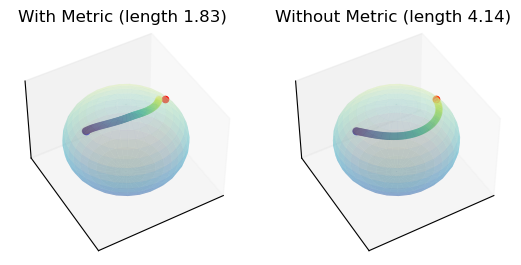

In [134]:
#Loading the model
models = ["With Metric (length 1.83)", "Without Metric (length 4.14)"]
ckpt = ['../notebooks/netv1_sphere_smetric.pt', "../notebooks/netv1_sphere_mse.pt"] 
fig = plt.figure()
for i, model in enumerate(models):
    ax = fig.add_subplot(1,2,i+1,projection="3d")
    net = torch.load(ckpt[i])
    net.eval()
    augmentations = AugmentationModule(sphere_reg=1)
    aug_net = AugmentedVectorField(net, augmentations.regs)
    aug_node = Sequential(
    augmentations.augmenter, NeuralODE(aug_net, sensitivity="adjoint", solver="rk4"))
    _, out = aug_node(x0, torch.linspace(0, 1, 51))
    path = polar_to_euc(out.detach().numpy()[:, 0, 1:])
    geodesic = great_circle(x0_e, x1_e, np.linspace(init, -end, 100).reshape(100, 1))
    ax.scatter(path[:, 0], path[:, 1], path[:, 2], c=list(range(51)))
    ax.scatter(x0_e[0, 0], x0_e[0, 1], x0_e[0, 2], c="blue")
    ax.scatter(x1_e[0, 0], x1_e[0, 1], x1_e[0, 2], c="red")
    u, v = np.mgrid[0 : 2 * np.pi : 30j, 0 : np.pi : 20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
    ax.view_init(45,60)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    ax.set_title(models[i])

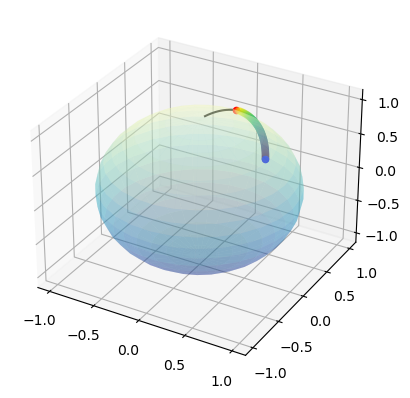

In [27]:
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(path_euc[:, 0], path_euc[:, 1], path_euc[:, 2], c=list(range(51)))
ax.scatter(x0_e[0, 0], x0_e[0, 1], x0_e[0, 2], c="blue")
ax.scatter(x1_e[0, 0], x1_e[0, 1], x1_e[0, 2], c="red")
u, v = np.mgrid[0 : 2 * np.pi : 30j, 0 : np.pi : 20j]
x = np.cos(u) * np.sin(v)
y = np.sin(u) * np.sin(v)
z = np.cos(v)
ax.plot_surface(x, y, z, cmap=plt.cm.YlGnBu_r, alpha=0.3)
ax.plot(geodesic[:, 0], geodesic[:, 1], geodesic[:, 2], c="black")
plt.show()

In [ ]:
x0, x1

In [ ]:
path[]

In [ ]:
torch.cat([x0, x1])

In [ ]:
import scprep

fig, ax = plt.subplots(1, 1)
scprep.plot.scatter2d(path, ax=ax)
scprep.plot.scatter2d(torch.cat([x0, x1]).numpy(), ax=ax)

<AxesSubplot: >

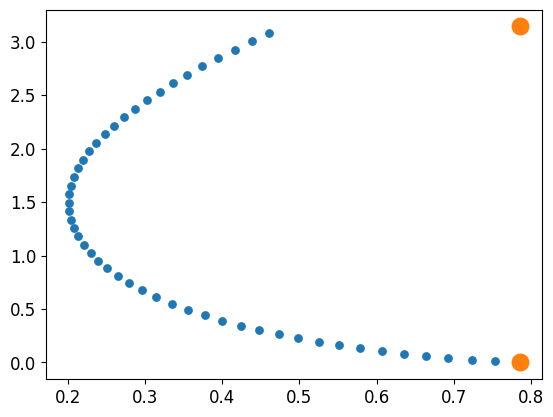

In [205]:
import scprep

fig, ax = plt.subplots(1, 1)
scprep.plot.scatter2d(path, ax=ax)
scprep.plot.scatter2d(torch.cat([x0, x1]).numpy(), ax=ax)